[原版（英文）图书地址](https://www.oreilly.com/library/view/feature-engineering-for/9781491953235/)

**翻译**：[apachecn](https://github.com/apachecn)，[翻译版本地址](https://github.com/apachecn/feature-engineering-for-ml-zh)

**代码修改和整理**：[黄海广](https://github.com/fengdu78)，原文修改成jupyter notebook格式，并增加和修改了部分代码，测试全部通过，所有数据集已经放在[百度云](data/README.md)下载。

# 四、特征缩放的效果：从词袋到 TF-IDF

> 译者：[@gin](https://github.com/tirtile)
> 
> 校对者：[@HeYun](https://github.com/KyrieHee)

字袋易于生成，但远非完美。假设我们平等的统计所有单词，有些不需要的词也会被强调。在第三章提过一个例子，Emma and the raven。我们希望在文档表示中能强调两个主要角色。示例中，“Eama”和“raven”都出现了3词，但是“the”的出现高达8次，“and”出现了次，另外“it”以及“was”也都出现了4词。仅仅通过简单的频率统计，两个主要角色并不突出。这是有问题的。

其他的像是“magnificently,” “gleamed,” “intimidated,” “tentatively,” 和“reigned,”这些辅助奠定段落基调的词也是很好的选择。它们表示情绪，这对数据科学家来说可能是非常有价值的信息。 所以，理想情况下，我们会倾向突出对有意义单词的表示。


## Tf-Idf: 词袋的小转折

Tf-Idf 是词袋的一个小小的转折。它表示词频-逆文档频。tf-idf不是查看每个文档中每个单词的原始计数，而是查看每个单词计数除以出现该单词的文档数量的标准化计数。
$$
{bow}(w, d)=\# \text {times} \text { word } w \text { appears in document } d
$$
$$
t f-i d f(w, d)=\frac{{bow}(w, d) \times N}{(\# \text {documents in which word w appears)}}
$$


$N$代表数据集中所有文档的数量。分数$\frac{{bow}(w, d) \times N}{(\# \text {documents in which word w appears)}}$就是所谓的逆文件频率。如果一个单词出现在许多文档中，则其逆文档频率接近1。如果单词出现在较少文档中，则逆文档频率要高得多。

或者，我们可以对原始逆文档频率进行对数转换，可以将1变为0，并使得较大的数字（比1大得多）变小。（稍后更多内容）

如果我们定义 tf-idf 为：

$$
t f-i d f(w, d)=\frac{{bow}(w, d) \times N}{(\# \text {documents in which word w appears)}}
$$

那么每个文档中出现的单词都将被有效清零，并且只出现在少数文档中的单词的计数将比以前更大。

让我们看一些图片来了解它的具体内容。图4-1展示了一个包含4个句子的简单样例：“it is a puppy,” “it is a cat,” “it is a kitten,” 以及 “that is a dog and this is a pen.” 我们将这些句子绘制在“puppy”，“cat”以及“is”三个词的特征空间上。

![图 4-1: 关于猫和狗的四个句子](images/chapter4/4-1.png)

<center><h5>图 4-1: 关于猫和狗的四个句子</h5></center>

现在让我们看看对逆文档频进行对数变换之后，相同四个句子的tf-idf表示。 图4-2显示了相应特征空间中的文档。可以注意到，单词“is”被有效地消除，因为它出现在该数据集中的所有句子中。另外，单词“puppy”和“cat”都只出现在四个句子中的一个句子中，所以现在这两个词计数得比之前更高（$log(4)=1.38...>1$）。因此tf-idf使罕见词语更加突出，并有效地忽略了常见词汇。它与第3章中基于频率的滤波方法密切相关，但比放置严格截止阈值更具数学优雅性。
![Figure 4-2: 图4-1中四个句子的Tf-idf表示](images/chapter4/4-2.png)

<center><h5>Figure 4-2: 图4-1中四个句子的Tf-idf表示</h5></center>


## Tf-Idf的含义

Tf-idf使罕见的单词更加突出，并有效地忽略了常见单词。

## 测试

Tf-idf通过乘以一个常量来转换字数统计特性。因此，它是特征缩放的一个例子，这是第2章介绍的一个概念。特征缩放在实践中效果有多好？ 我们来比较简单文本分类任务中缩放和未缩放特征的表现。 coding时间到！

本次实践， 我们依旧采用了Yelp评论数据集。Yelp数据集挑战赛第6轮包含在美国六个城市将近一百六十万商业评论。
### 样例4-1：使用python加载和清洗Yelp评论数据集

In [1]:
import json
import pandas as pd
## Load Yelp Business data
biz_f = open('data/yelp_academic_dataset_business.json')
biz_df = pd.DataFrame([json.loads(x) for x in biz_f.readlines()])
biz_f.close()
## Load Yelp Reviews data
review_file = open('data/yelp_academic_dataset_review.json')
review_df = pd.DataFrame([json.loads(x) for x in review_file.readlines()])
review_file.close()

In [2]:
biz_df.shape

(11537, 13)

In [3]:
review_df.shape

(229907, 8)

In [4]:
# Pull out only Nightlife and Restaurants businesses
two_biz = biz_df[biz_df.apply(
    lambda x: 'Nightlife' in x['categories'] or 'Restaurants' in x['categories'
                                                                   ],
    axis=1)]

In [5]:
two_biz.shape

(4816, 13)

In [6]:
biz_df.shape

(11537, 13)

In [7]:
# Join with the reviews to get all reviews on the two types of business
twobiz_reviews = two_biz.merge(review_df, on='business_id', how='inner')

In [8]:
twobiz_reviews.shape

(166038, 20)

In [9]:
# Trim away the features we won't use
twobiz_reviews = twobiz_reviews[['business_id',
                        'name',
                        'stars_y',
                        'text',
                        'categories']]

In [10]:
# Create the target column--True for Nightlife businesses, and False otherwise
twobiz_reviews['target'] = twobiz_reviews.apply(
    lambda x: 'Nightlife' in x['categories'], axis=1)

## 建立分类数据集

让我们看看是否可以使用评论来区分餐厅或夜生活场所。为了节省训练时间，仅使用一部分评论。这两个类别之间的评论数目有很大差异。这是所谓的类不平衡数据集。对于构建模型来说，不平衡的数据集存在着一个问题:这个模型会把大部分精力花费在比重更大的类上。由于我们在这两个类别都有大量的数据，解决这个问题的一个比较好方法是将数目较大的类（餐厅）进行下采样，使之与数目较小的类（夜生活）数目大致相同。下面是一个示例工作流程。

1. 随机抽取10%夜生活场所评论以及2.1%的餐厅评论（选取合适的百分比使得每个种类的数目大致一样）

2. 将数据集分成比例为7：3的训练集和测试集。在这个例子里，训练集包括29，264条评论，测试集有12542条。

3. 训练数据包括46，924个不同的单词，这是词袋表示中特征的数量。

### 样例4-2：创建一个分类数据集

In [11]:
# Create a class-balanced subsample to play with
nightlife = twobiz_reviews[
    twobiz_reviews.apply(lambda x: 'Nightlife' in x['categories'], axis=1)]
restaurants = twobiz_reviews[
    twobiz_reviews.apply(lambda x: 'Restaurants' in x['categories'], axis=1)]

In [12]:
nightlife.shape

(30136, 6)

In [13]:
restaurants.shape

(158430, 6)

In [14]:
nightlife_subset = nightlife.sample(frac=0.1, random_state=123)
restaurant_subset = restaurants.sample(frac=0.021, random_state=123)

In [15]:
nightlife_subset.shape

(3014, 6)

In [16]:
restaurant_subset.shape

(3327, 6)

In [17]:
combined = pd.concat([nightlife_subset, restaurant_subset])

In [18]:
combined['target'] = combined.apply(
    lambda x: 'Nightlife' in x['categories'], axis=1)

In [19]:
combined.head()

,business_id,name,stars_y,text,categories,target
103709,2ceeU8e3nZjaPfGmLwh4kg,Casey Moore's Oyster House,2,Been here a couple times over the last few yea...,"[Bars, Seafood, Irish, Pubs, Nightlife, Restau...",True
52043,JokKtdXU7zXHcr20Lrk29A,Four Peaks Brewing Co,5,Over the top service. One of my favorite meals...,"[Bars, Food, Breweries, Pubs, Nightlife, Ameri...",True
134438,-yxfBYGB6SEqszmxJxd97A,Quiessence Restaurant,4,On a trip where I ate at some very nice and up...,"[Wine Bars, Bars, American (New), Nightlife, R...",True
142453,fjAQGf-iJlVjD2vizzuORQ,Giligin's Bar,4,Stumbled on Giligins a few nights ago. I knew...,"[Bars, Nightlife]",True
67583,DjdA1xbHki_lopCSxf-Egg,Greasewood Flat,5,Thinking about one of these burgers is making ...,"[Burgers, Bars, Hot Dogs, Nightlife, Restaurants]",True


In [20]:
# Split into training and test data sets
import sklearn.model_selection as modsel
training_data, test_data = modsel.train_test_split(
    combined, train_size=0.7, random_state=123)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [21]:
training_data.shape

(4438, 6)

In [22]:
test_data.shape

(1903, 6)

## 用tf-idf转换缩放词袋


这个实验的目标是比较词袋，tf-idf以及L2归一化对于线性分类的作用。注意，做tf-idf接着做L2归一化和单独做L2归一化是一样的。所以我们需要只需要3个特征集合：词袋，tf-idf，以及逐词进行L2归一化后的词袋。

在这个例子中，我们将使用Scikit-learn的CountVectorizer将评论文本转化为词袋。所有的文本特征化方法都依赖于标记器（tokenizer），该标记器能够将文本字符串转换为标记（词）列表。在这个例子中，Scikit-learn的默认标记模式是查找2个或更多字母数字字符的序列。标点符号被视为标记分隔符。

## 测试集上进行特征缩放

特征缩放的一个细微之处是它需要了解我们在实践中很可能不知道的特征统计，例如均值，方差，文档频率，L2范数等。为了计算tf-idf表示，我们不得不根据训练数据计算逆文档频率，并使用这些统计量来调整训练和测试数据。在Scikit-learn中，将特征变换拟合到训练集上相当于收集相关统计数据。然后可以将拟合过的变换应用于测试数据。

### 样例4-3：特征变换

In [23]:
from sklearn.feature_extraction import text
# Represent the review text as a bag-of-words
bow_transform = text.CountVectorizer()
X_tr_bow = bow_transform.fit_transform(training_data['text'])

In [24]:
X_te_bow = bow_transform.transform(test_data['text'])

In [25]:
len(bow_transform.vocabulary_)

18565

In [26]:
y_tr = training_data['target']
y_te = test_data['target']

In [27]:
# Create the tf-idf representation using the bag-of-words matrix
tfidf_trfm = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_trfm.fit_transform(X_tr_bow)

In [28]:
X_te_tfidf = tfidf_trfm.transform(X_te_bow)

In [29]:
import sklearn.preprocessing as preproc
# Just for kicks, l2-normalize the bag-of-words representation
X_tr_l2 = preproc.normalize(X_tr_bow, axis=0)
X_te_l2 = preproc.normalize(X_te_bow, axis=0)

当我们使用训练统计来衡量测试数据时，结果看起来有点模糊。测试集上的最小-最大比例缩放不再整齐地映射到零和一。L2范数，平均数和方差统计数据都将显得有些偏离。这比缺少数据的问题好一点。例如，测试集可能包含训练数据中不存在的单词，并且对于新的单词没有相应的文档频。通常的解决方案是简单地将测试集中新的单词丢弃。这似乎是不负责任的，但训练集上的模型在任何情况下都不会知道如何处理新词。一种稍微不太好的方法是明确地学习一个“垃圾”单词，并将所有罕见的频率单词映射到它，即使在训练集中也是如此，正如“罕见词汇”中所讨论的那样。

## 使用逻辑回归进行分类

逻辑回归是一个简单的线性分类器。通过对输入特征的加权组合，输入到一个sigmoid函数。sigmoid函数将任何实数平滑的映射到介于0和1之间。如图4-3绘制sigmoid函数曲线。由于逻辑回归比较简单，因此它通常是最先接触的分类器。

![Figure 4-3: sigmoid函数](images/chapter4/4-3.png)

<center><h5>Figure 4-3: sigmoid函数</h5></center>

图4-3是sigmoid函数的插图。该函数将输入的实数x转换为一个0到1之间的数。它有一组参数w，表示围绕中点0.5增加的斜率。截距项b表示函数输出穿过中点的输入值。如果sigmoid输出大于0.5，则逻辑分类器将预测为正例，否则为反例。通过改变w和b，可以控制决策的改变，以及决策响应该点周围输入值变化的速度。

### 样例4-4：使用默认参数训练逻辑回归分类器

In [30]:
from sklearn.linear_model import LogisticRegression

In [32]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    ## Helper function to train a logistic classifier and score on test data
    m = LogisticRegression(C=_C).fit(X_tr, y_tr)
    s = m.score(X_test, y_test)
    print('Test score with', description, 'features:', s)
    return m

In [33]:
m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized')
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Test score with bow features: 0.7677351550183921
Test score with l2-normalized features: 0.7856016815554387
Test score with tf-idf features: 0.7540725170782975


矛盾的是，结果表明最准确的分类器是使用BOW特征的分类器。出乎意料我们之外。事实证明，造成这种情况的原因是没有很好地“调整”分类器，这是比较分类器时一个常见的错误。

## 使用正则化调整逻辑回归

逻辑回归有些华而不实。 当特征的数量大于数据点的数量时，找到最佳模型的问题被认为是欠定的。 解决这个问题的一种方法是在训练过程中增加额外的约束条件。 这就是所谓的正则化，技术细节将在下一节讨论。

逻辑回归的大多数实现允许正则化。为了使用这个功能，必须指定一个正则化参数。正则化参数是在模型训练过程中未自动学习的超参数。相反，他们必须手动进行调整，并将其提供给训练算法。这个过程称为超参数调整。（有关如何评估机器学习模型的详细信息，请参阅评估机器学习模型（Evaluating Machine Learning Models））.调整超参数的一种基本方法称为网格搜索：指定一个超参数值网格，并且调谐器以编程方式在网格中搜索最佳超参数设置 格。 找到最佳超参数设置后，使用该设置对整个训练集进行训练，并比较测试集上这些同类最佳模型的性能。

## 重点：比较模型时调整超参数

比较模型或特征时，调整超参数非常重要。 软件包的默认设置将始终返回一个模型。 但是除非软件在底层进行自动调整，否则很可能会返回一个基于次优超参数设置的次优模型。 分类器性能对超参数设置的敏感性取决于模型和训练数据的分布。 逻辑回归对超参数设置相对稳健（或不敏感）。 即便如此，仍然有必要找到并使用正确的超参数范围。 否则，一个模型相对于另一个模型的优点可能仅仅是由于参数的调整，并不能反映模型或特征的实际表现。

即使是最好的自动调整软件包仍然需要指定搜索的上限和下限，并且找到这些限制可能需要几次手动尝试。

在本例中，我们手动将逻辑正则化参数的搜索网格设置为{1e-5，0.001，0.1，1，10，100}。 上限和下限花费了几次尝试来缩小范围。 表4-1给出了每个特征集合的最优超参数设置。

<center><h5>Table4-1.对夜场和餐厅的Yelp评论进行逻辑回归的最佳参数设置</h5></center>

 Method | L2 Regularization
--------|-----------
BOW | 0.1 
L2-normalized| 10
TF-IDF | 0.01

我们也想测试tf-idf和BOW之间的精度差异是否是由于噪声造成的。 为此，我们使用k折交叉验证来模拟具有多个统计独立的数据集。它将数据集分为k个折叠。交叉验证过程通过分割后的数据进行迭代，使用除除去某一折之外的所有内容进行训练，并用那一折验证结果。Scikit-Learn中的GridSearchCV功能通过交叉验证进行网格搜索。 图4-4显示了在每个特征集上训练的模型的精度测量分布箱线图。 盒子中线表示中位精度，盒子本身表示四分之一和四分之三分位之间的区域，而线则延伸到剩余的分布。


### 通过重采样估计方差

现代统计方法假设底层数据是随机分布的。 数据导出模型的性能测量也受到随机噪声的影响。 在这种情况下，基于相似数据的数据集，不止一次进行测量总是比较好的。 这给了我们一个测量的置信区间。 K折交叉验证就是这样一种策略。 重采样是另一种从相同底层数据集生成多个小样本的技术。 有关重采样的更多详细信息，请参见评估机器学习模型。

### 样例4-5：使用网格搜索调整逻辑回归超参数

In [34]:
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
bow_search = modsel.GridSearchCV(
    LogisticRegression(), cv=5, param_grid=param_grid_)
l2_search = modsel.GridSearchCV(
    LogisticRegression(), cv=5, param_grid=param_grid_)
tfidf_search = modsel.GridSearchCV(
    LogisticRegression(), cv=5, param_grid=param_grid_)

In [35]:
bow_search.fit(X_tr_bow, y_tr)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
bow_search.best_score_

0.765209553853087

In [37]:
l2_search.fit(X_tr_l2, y_tr)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
l2_search.best_score_

0.7708427219468229

In [39]:
tfidf_search.fit(X_tr_tfidf, y_tr)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [40]:
tfidf_search.best_score_

0.7893195132942767

In [41]:
bow_search.best_params_

{'C': 0.1}

In [42]:
l2_search.best_params_

{'C': 1.0}

In [43]:
tfidf_search.best_params_

{'C': 0.001}

In [44]:
bow_search.cv_results_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\

{'mean_fit_time': array([0.02672362, 0.04170284, 0.14934993, 0.23928313, 0.37921972,
        0.42493615]),
 'mean_score_time': array([0.00079846, 0.00099654, 0.00039368, 0.00079846, 0.00059032,
        0.00039887]),
 'mean_test_score': array([0.54912123, 0.72239748, 0.76520955, 0.75259126, 0.74132492,
        0.72577738]),
 'mean_train_score': array([0.54912118, 0.77022266, 0.94338642, 0.99273309, 0.99909867,
        0.99988734]),
 'param_C': masked_array(data=[1e-05, 0.001, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-05},
  {'C': 0.001},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0}],
 'rank_test_score': array([6, 5, 1, 2, 3, 4]),
 'split0_test_score': array([0.54842342, 0.76013514, 0.78490991, 0.76576577, 0.75112613,
        0.73423423]),
 'split0_train_score': array([0.54901408, 0.76676056, 0.94309859, 0.99239437, 0.99887324,
        0.99971831]),
 'split1_

In [45]:
########
# Plot the cross validation results in a box-and-whiskers plot to
# visualize and compare classifier performance
########
search_results = pd.DataFrame.from_dict({
    'bow':
    bow_search.cv_results_['mean_test_score'],
    'tfidf':
    tfidf_search.cv_results_['mean_test_score'],
    'l2':
    l2_search.cv_results_['mean_test_score']
})
search_results

,bow,l2,tfidf
0,0.549121,0.548220,0.589004
1,0.722397,0.548220,0.789320
2,0.765210,0.593961,0.759351
3,0.752591,0.770843,0.747634
4,0.741325,0.769491,0.730509
5,0.725777,0.751465,0.702118


Table4-2.每个超参数设置的平均交叉验证分类器准确度。

## 画出交叉验证结果

In [46]:
# Our usual matplotlib incantations. Seaborn is used here to make
# the plot pretty
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

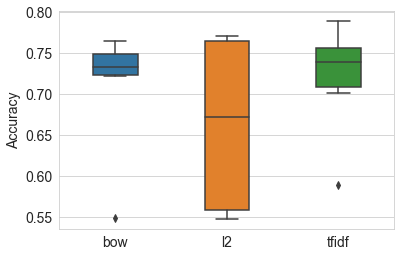

In [47]:
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=14)
# plt.savefig('tfidf_gridcv_results.png')

<center>Figure 4-4: 分类器精度在每个特征集和正则化设置下的分布。 准确度是以5折交叉验证的平均准确度来衡量的</center>


在图4-4中，L2归一化后的特征结果看起来非常糟糕。 但不要被蒙蔽了 。准确率低是由于正则化参数设置不恰当造成的 - 实际证明次优超参数会得到相当错误的结论。 如果我们使用每个特征集的最佳超参数设置来训练模型，则不同特征集的测试精度非常接近。

### 示例4-6：最终的训练和测试步骤来比较不同的特征集

In [48]:
m1 = simple_logistic_classify(
    X_tr_bow, y_tr, X_te_bow, y_te, 'bow', _C=bow_search.best_params_['C'])
m2 = simple_logistic_classify(
    X_tr_l2,
    y_tr,
    X_te_l2,
    y_te,
    'l2-normalized',
    _C=l2_search.best_params_['C'])
m3 = simple_logistic_classify(
    X_tr_tfidf,
    y_tr,
    X_te_tfidf,
    y_te,
    'tf-idf',
    _C=tfidf_search.best_params_['C'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Test score with bow features: 0.7682606410930111
Test score with l2-normalized features: 0.7856016815554387
Test score with tf-idf features: 0.792433000525486


In [49]:
bow_search.cv_results_['mean_test_score']

array([0.54912123, 0.72239748, 0.76520955, 0.75259126, 0.74132492,
       0.72577738])

<center>Table4-3.BOW, Tf-Idf,以及L2正则化的最终分类精度</center>

Feature Set |Test Accuracy
--------|-----------
Bag-of-Words | 0.7682606410930111
L2 -normalized | 0.7856016815554387
Tf-Idf | 0.792433000525486

适当的调整提高了所有特征集的准确性，并且所有特征集在正则化后进行逻辑回归得到了相近的准确率。tf-idf模型准确率略高，但这点差异可能没有统计学意义。 这些结果是完全神秘的。 如果特征缩放效果不如vanilla词袋的效果好，那为什么要这么做呢？ 如果tf-idf没有做任何事情，为什么总是要这么折腾？ 我们将在本章的其余部分中探索答案。

## 深入：发生了什么？
为了明白结果背后隐含着什么，我们必须考虑模型是如何使用特征的。对于类似逻辑回归这种线性模型来说，是通过所谓的数据矩阵的中间对象来实现的。
数据矩阵包含以固定长度平面向量表示的数据点。 根据词袋向量，数据矩阵也被称为文档词汇矩阵。 图3-1显示了一个向量形式的词袋向量，图4-1显示了特征空间中的四个词袋向量。 要形成文档词汇矩阵，只需将文档向量取出，平放，然后将它们堆叠在一起。 这些列表示词汇表中所有可能的单词。 由于大多数文档只包含所有可能单词的一小部分，因此该矩阵中的大多数都是零，是一个稀疏矩阵。

![Figure 4-5: 包含5个文档7个单词的文档-词汇矩阵](images/chapter4/4-5.png)

<center>Figure 4-5: 包含5个文档7个单词的文档-词汇矩阵</center>

特征缩放方法本质上是对数据矩阵的列操作。特别的，tf-idf和L2归一化都将整列（例如n-gram特征）乘上一个常数。

## Tf-idf=列缩放
Tf-idf和L2归一化都是数据矩阵上的列操作。 正如附录A所讨论的那样，训练线性分类器归结为寻找最佳的线性组合特征，这是数据矩阵的列向量。 解空间的特征是列空间和数据矩阵的空间。训练过的线性分类器的质量直接取决于数据矩阵的零空间和列空间。 大的列空间意味着特征之间几乎没有线性相关性，这通常是好的。 零空间包含“新”数据点，不能将其表示为现有数据的线性组合; 大的零空间可能会有问题。（强烈建议希望对诸如线性决策表面，特征分解和矩阵的基本子空间等概念进行的回顾的读者阅读附录A。)

列缩放操作如何影响数据矩阵的列空间和空间？ 答案是“不是很多”。但是在tf-idf和L2归一化之间有一个小小的差别。

由于几个原因，数据矩阵的零空间可能很大。 首先，许多数据集包含彼此非常相似的数据点。 这使得有效的行空间与数据集中数据的数量相比较小。 其次，特征的数量可以远大于数据的数量。 词袋特别擅长创造巨大的特征空间。 在我们的Yelp例子中，训练集中有29K条评论，但有47K条特征。 而且，不同单词的数量通常随着数据集中文档的数量而增长。 因此，添加更多的文档不一定会降低特征与数据比率或减少零空间。

在词袋模型中，与特征数量相比，列空间相对较小。 在相同的文档中可能会出现数目大致相同的词，相应的列向量几乎是线性相关的，这导致列空间不像它可能的那样满秩。 这就是所谓的秩亏。 （就像动物缺乏维生素和矿物质一样，矩阵秩亏，输出空间也不会像应该那样蓬松）。

秩亏行空间和列空间导致模型空间预留过度的问题。 线性模型为数据集中的每个特征配置权重参数。 如果行和列空间满秩$^1$，那么该模型将允许我们在输出空间中生成任何目标向量。 当模型不满秩时，模型的自由度比需要的更大。 这使得找出解决方案变得更加棘手。

可以通过特征缩放来解决数据矩阵的不满秩问题吗？ 让我们来看看。

列空间被定义为所有列向量的线性组合：$a_{1} v_{1}+a_{2} v_{2}+\ldots+a_{n} v_{n}$。比方说，特征缩放用一个常数倍来替换一个列向量，$v_{1}=c v_{1}$。但是我们仍然可以通过用$\widetilde{a_{1}}=\frac{a_{1}}{c}$来替换$a_1$，生成原始的线性组合。看起来，特征缩放不会改变列空间的秩。类似地，特征缩放不会影响空间的秩，因为可以通过反比例缩放权重向量中的对应条目来抵消缩放的特征列。

但是，仍然存在一个陷阱。 如果标量为0，则无法恢复原始线性组合;$v_1$消失了。 如果该向量与所有其他列线性无关，那么我们已经有效地缩小了列空间并放大了零空间。

如果该向量与目标输出不相关，那么这将有效地修剪掉噪声信号，这是一件好事。 这是tf-idf和L2归一化之间的关键区别。 L2归一化永远不会计算零的范数，除非该向量包含全零。 如果向量接近零，那么它的范数也接近于零。 按照小规范划分将突出向量并使其变大。

另一方面，如图4-2所示，Tf-idf可以生成接近零的缩放因子。 当这个词出现在训练集中的大量文档中时，会发生这种情况。 这样的话有可能与目标向量没有很强的相关性。 修剪它可以使模型专注于列空间中的其他方向并找到更好的解决方案。 准确度的提高可能不会很大，因为很少有噪声方向可以通过这种方式修剪。

在特征缩放的情况下，L2和tf-idf对于模型的收敛速度确实有促进。 这是该数据矩阵有一个更小的条件数的标志。 事实上，L2归一化使得条件数几乎一致。 但情况并非条件数越多，解决方案越好。 在这个实验中，L2归一化收敛比BOW或tf-idf快得多。 但它对过拟合也更敏感：它需要更多的正则化，并且对优化期间的迭代次数更敏感。

## 总结

在本章中，我们使用tf-idf作为入口点，详细分析特征变换如何影响（或不）模型。Tf-idf是特征缩放的一个例子，所以我们将它的性能与另一个特征缩放方法-L2标准化进行了对比。

结果并不如预期。Tf-idf和L2归一化不会提高最终分类器的准确度，而不会超出纯词袋。 在获得了一些统计建模和线性代数处理知识之后，我们意识到了为什么：他们都没有改变数据矩阵的列空间。

两者之间的一个小区别是，tf-idf可以“拉伸”字数以及“压缩”它。 换句话说，它使一些数字更大，其他数字更接近
归零。 因此，tf-idf可以完全消除无意义的单词。

我们还发现了另一个特征缩放效果：它改善了数据矩阵的条件数，使线性模型的训练速度更快。 L2标准化和tf-idf都有这种效果。

总而言之，正确的特征缩放可以有助于分类。 正确的缩放突出了信息性词语，并降低了常见单词的权重。 它还可以改善数据矩阵的条件数。 正确的缩放并不一定是统一的列缩放。

这个故事很好地说明了在一般情况下分析特征工程的影响的难度。 更改特征会影响训练过程和随后的模型。 线性模型是容易理解的模型。 然而，它仍然需要非常谨慎的实验方法和大量的深刻的数学知识来区分理论和实际的影响。 对于更复杂的模型或特征转换来说，这是不可能的。

## 参考书目

Strang, Gilbert. 2006. Linear Algebra and Its Applications. Brooks Cole Cengage, fourth edition.

$^1$ 严格地说，矩阵矩阵的行空间和列空间不能都是满秩的。 两个子空间的最大秩是m（行数）和n（列数）中的较小者。 这就是我们所说的满秩。